# Explore Exercises

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date.
<br><br>
For both datasets you should choose a method of splitting your data and only explore the training split.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from warnings import filterwarnings

import acquire
import prepare

In [2]:
filterwarnings('ignore')

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [3]:
df = prepare.prepare_store_data(acquire.load_heb_data())

In [4]:
df_total = df.resample('D').sum()
# df_median = df.resample('D').median()

In [5]:
print('Date Range:', df_total.index.min(), 'to', df_total.index.max())
print('Shape:', df_total.shape)

df_total.head(5)

Date Range: 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Shape: (1826, 10)


,item_id,quantity,sale_id,store_id,store_zipcode,item_price,item_upc12,item_upc14,month,sales_total
sale_date,,,,,,,,,,
2013-01-01 00:00:00+00:00,12750,13696.0,227794000,2750,39112400,2580.2,119234392245520,119234392245520,500,73844.01
2013-01-02 00:00:00+00:00,12750,13678.0,227794500,2750,39112400,2580.2,119234392245520,119234392245520,500,73570.58
2013-01-03 00:00:00+00:00,12750,14488.0,227795000,2750,39112400,2580.2,119234392245520,119234392245520,500,78169.48
2013-01-04 00:00:00+00:00,12750,15677.0,227795500,2750,39112400,2580.2,119234392245520,119234392245520,500,84467.73
2013-01-05 00:00:00+00:00,12750,16237.0,227796000,2750,39112400,2580.2,119234392245520,119234392245520,500,87621.85


In [6]:
# print('Date Range:', df_median.index.min(), 'to', df_median.index.max())
# print('Shape:', df_median.shape)

# df_median.head(5)

In [7]:
df_subset = df_total[['quantity', 'sales_total']]

In [8]:
df_subset.index = pd.to_datetime(df_subset.index.date)

# Splitting Time Series Data

## Sales Store Data

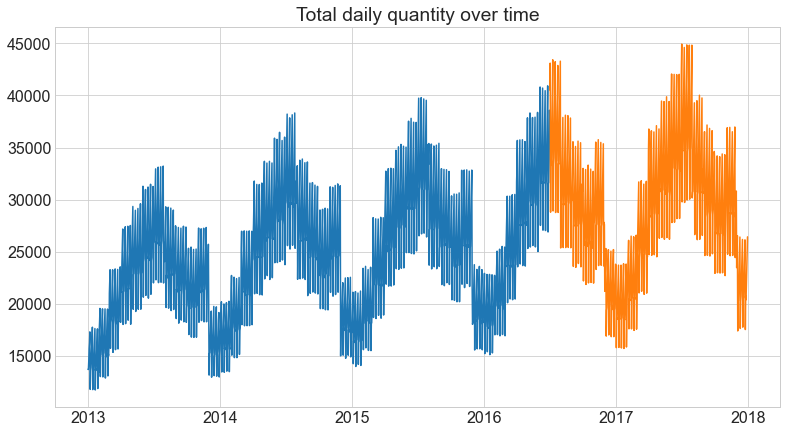

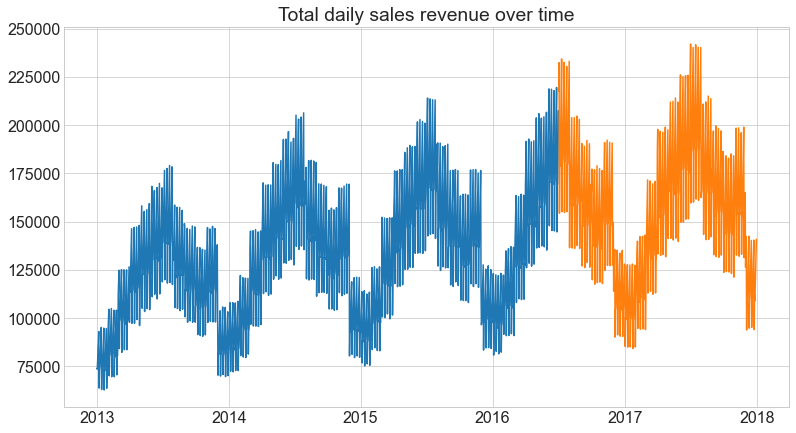

In [9]:
# Percentage based data splitting
train_size = .70
n = df_subset.shape[0]
test_start_index = round(train_size * n)

train = df_subset[:test_start_index]
test = df_subset[test_start_index:] 

plt.title('Total daily quantity over time')
plt.plot(train.index, train.quantity)
plt.plot(test.index, test.quantity);
plt.show()

plt.title('Total daily sales revenue over time')
plt.plot(train.index, train.sales_total)
plt.plot(test.index, test.sales_total);

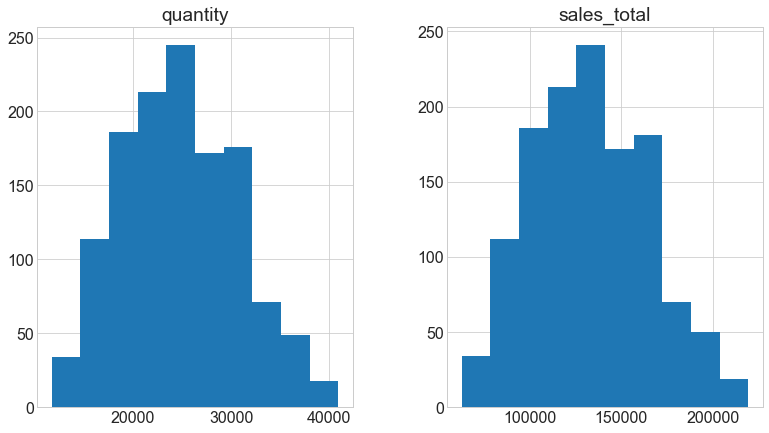

In [10]:
train.hist();

In [11]:
y = train.sales_total

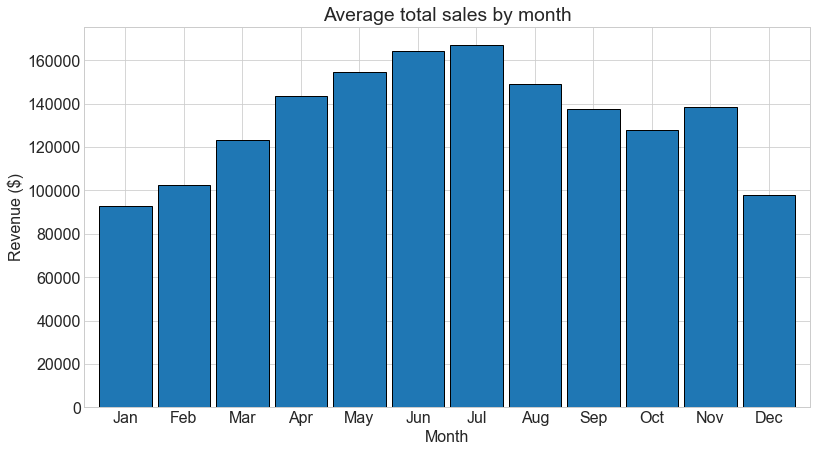

In [12]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar(width=.9, ec='black')

plt.xticks(rotation=0)
ax.set(title='Average total sales by month',
       xlabel='Month',
       ylabel='Revenue ($)')

ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()],
                   rotation=0);

In [13]:
y = pd.DataFrame(y).assign(day_of_week = y.index.day_name())

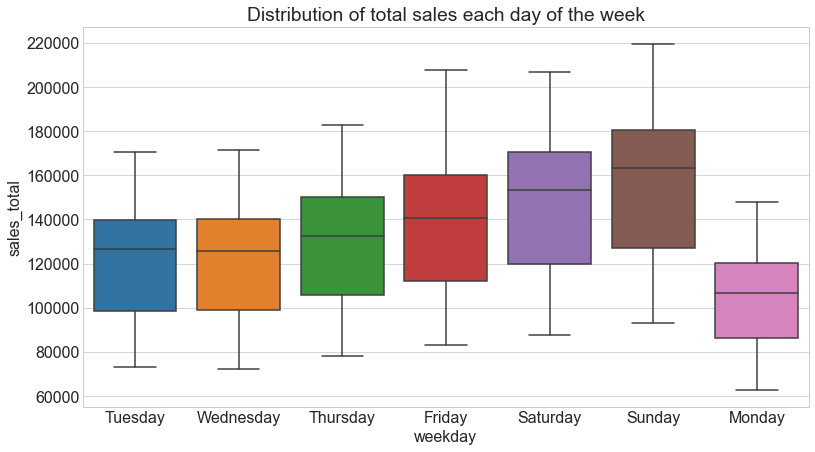

In [14]:
(
    y
    .assign(weekday=lambda df: df.index.day_name())
    .pipe((sns.boxplot, 'data'), y='sales_total', x='weekday')
)
plt.title('Distribution of total sales each day of the week');

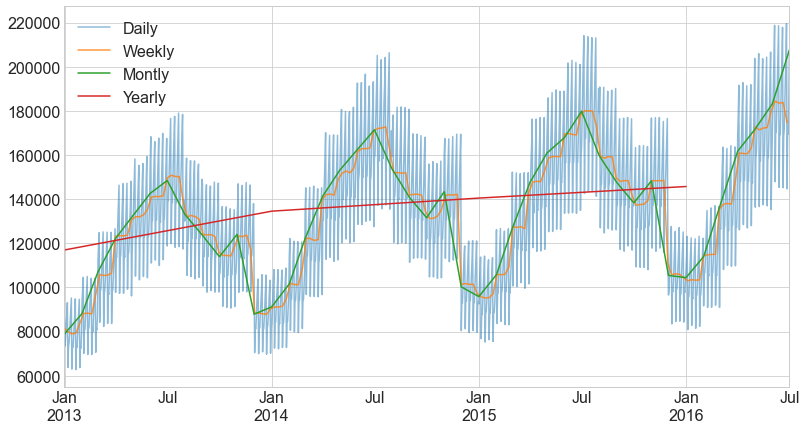

In [15]:
y.sales_total.resample('D').mean().plot(alpha=.5, label='Daily')
y.sales_total.resample('W').mean().plot(alpha=.8, label='Weekly')
y.sales_total.resample('M').mean().plot(label='Montly')
y.sales_total.resample('Y').mean().plot(label='Yearly')
plt.legend();

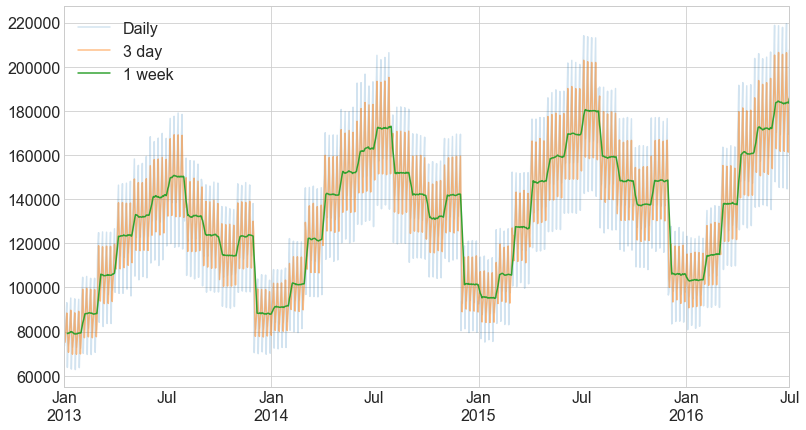

In [16]:
y.sales_total.plot(alpha=.2, label='Daily')
y.sales_total.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.sales_total.resample('D').mean().rolling(7).mean().plot(alpha=8, label='1 week')
plt.legend();

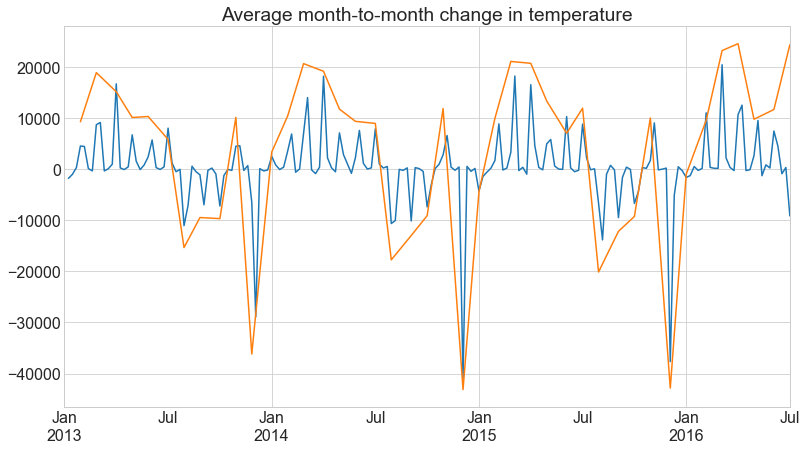

In [17]:
y.sales_total.resample('W').mean().diff().plot(title='Average week-to-week change in temperature')
y.sales_total.resample('M').mean().diff().plot(title='Average month-to-month change in temperature');

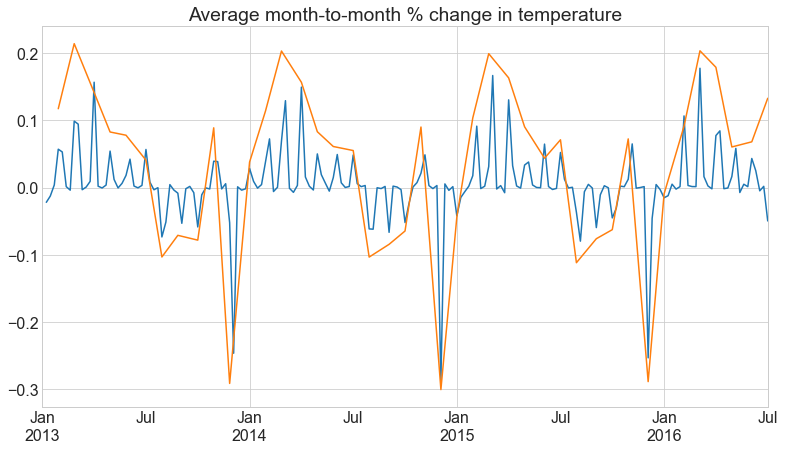

In [18]:
y.sales_total.resample('W').mean().pct_change().plot(title='Average week-to-week % change in temperature')
y.sales_total.resample('M').mean().pct_change().plot(title='Average month-to-month % change in temperature');

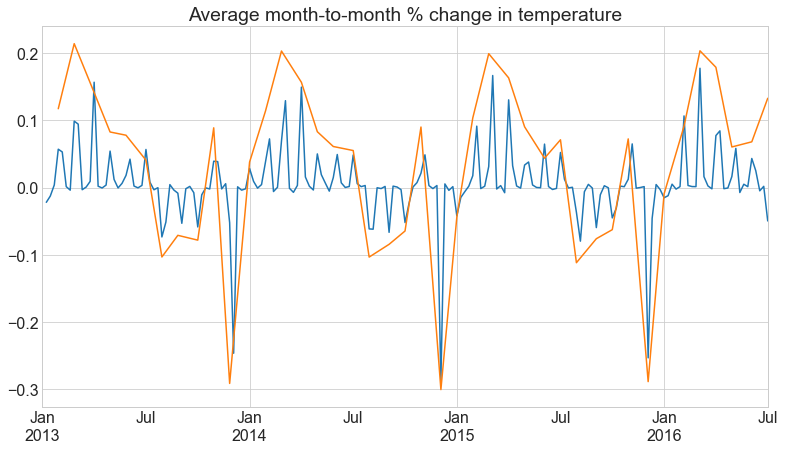

In [19]:
y.sales_total.resample('W').mean().pct_change().plot(title='Average week-to-week % change in temperature')
y.sales_total.resample('M').mean().pct_change().plot(title='Average month-to-month % change in temperature');

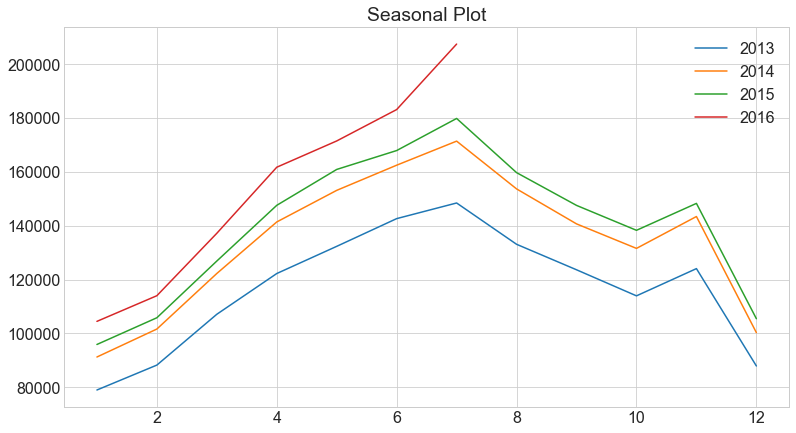

In [20]:
y.sales_total.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot');

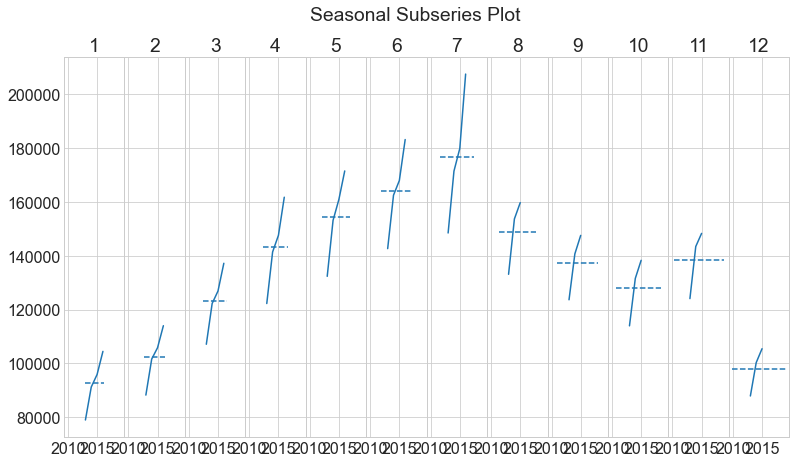

In [21]:
table = y.sales_total.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim(), ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

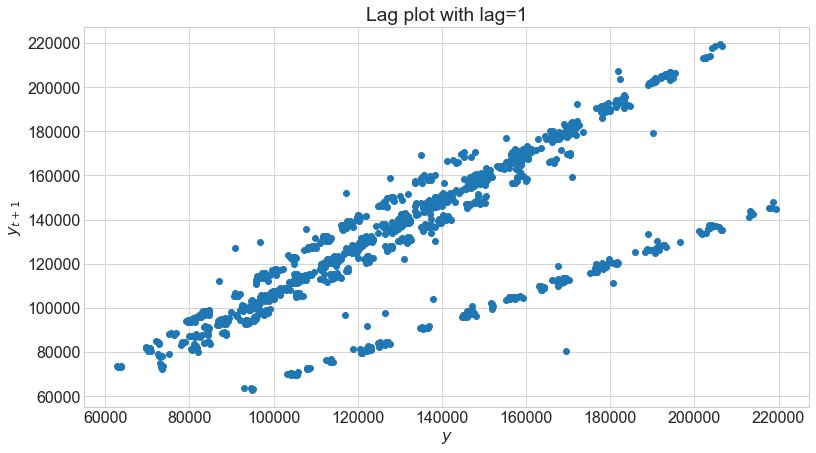

In [22]:
plt.scatter(y.sales_total, y.sales_total.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1');

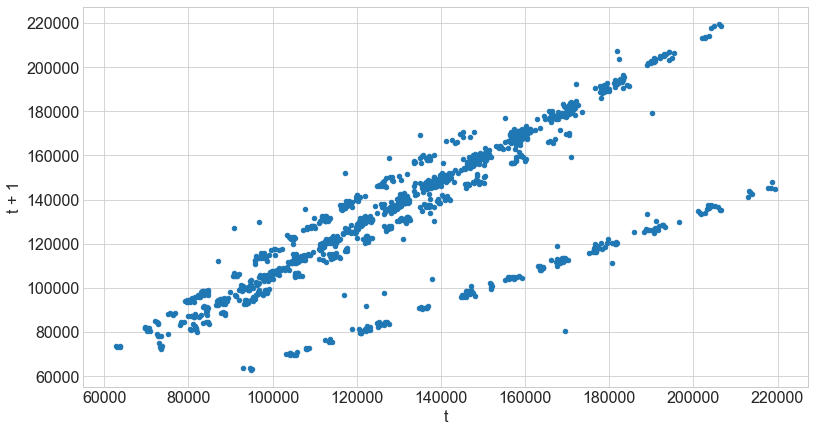

In [23]:
train['y(t + 1)'] = train.sales_total.shift(-1)
ax = train.plot.scatter(x='sales_total', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1');

,quantity,this_week,y(t + 1),the_next_week
2013-01-06,15177.833333,81794.583333,80116.838333,79990.601429
2013-01-13,14843.142857,79990.601429,79884.427143,78973.360000
2013-01-20,14707.142857,78973.360000,78938.260000,79272.691429
2013-01-27,14756.857143,79272.691429,79398.127143,83792.507143
2013-02-03,15575.285714,83792.507143,84716.047143,88227.801429
...,...,...,...,...
2016-06-05,33516.857143,179882.295714,181687.111429,184381.464286
2016-06-12,34253.000000,184381.464286,184019.655714,183473.044286
2016-06-19,34130.571429,183473.044286,183445.952857,183792.654286
2016-06-26,34247.714286,183792.654286,183719.510000,174646.958000


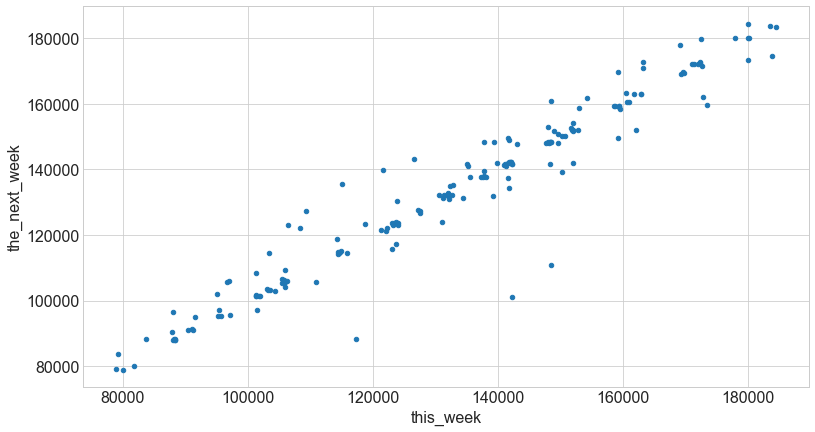

In [24]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.sales_total.shift(-1)
weekly = weekly.rename(columns={'sales_total': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

,quantity,this_week,y(t + 1),the_next_week,12_weeks_out
2013-01-06,15177.833333,81794.583333,80116.838333,79990.601429,106501.331429
2013-01-13,14843.142857,79990.601429,79884.427143,78973.360000,123193.640000
2013-01-20,14707.142857,78973.360000,78938.260000,79272.691429,123430.685714
2013-01-27,14756.857143,79272.691429,79398.127143,83792.507143,123345.042857
2013-02-03,15575.285714,83792.507143,84716.047143,88227.801429,123791.114286
...,...,...,...,...,...
2016-06-05,33516.857143,179882.295714,181687.111429,184381.464286,NaN
2016-06-12,34253.000000,184381.464286,184019.655714,183473.044286,NaN
2016-06-19,34130.571429,183473.044286,183445.952857,183792.654286,NaN
2016-06-26,34247.714286,183792.654286,183719.510000,174646.958000,NaN


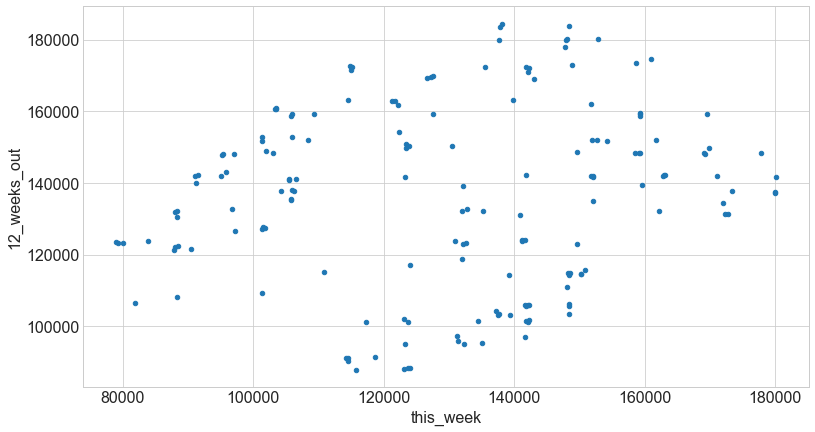

In [25]:
weekly['12_weeks_out'] = weekly.this_week.shift(-12)
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly

,quantity,this_week,y(t + 1),the_next_week,12_weeks_out,half_a_year_later
2013-01-06,15177.833333,81794.583333,80116.838333,79990.601429,106501.331429,149604.697143
2013-01-13,14843.142857,79990.601429,79884.427143,78973.360000,123193.640000,150789.424286
2013-01-20,14707.142857,78973.360000,78938.260000,79272.691429,123430.685714,150282.567143
2013-01-27,14756.857143,79272.691429,79398.127143,83792.507143,123345.042857,150242.265714
2013-02-03,15575.285714,83792.507143,84716.047143,88227.801429,123791.114286,139188.128571
...,...,...,...,...,...,...
2016-06-05,33516.857143,179882.295714,181687.111429,184381.464286,NaN,NaN
2016-06-12,34253.000000,184381.464286,184019.655714,183473.044286,NaN,NaN
2016-06-19,34130.571429,183473.044286,183445.952857,183792.654286,NaN,NaN
2016-06-26,34247.714286,183792.654286,183719.510000,174646.958000,NaN,NaN


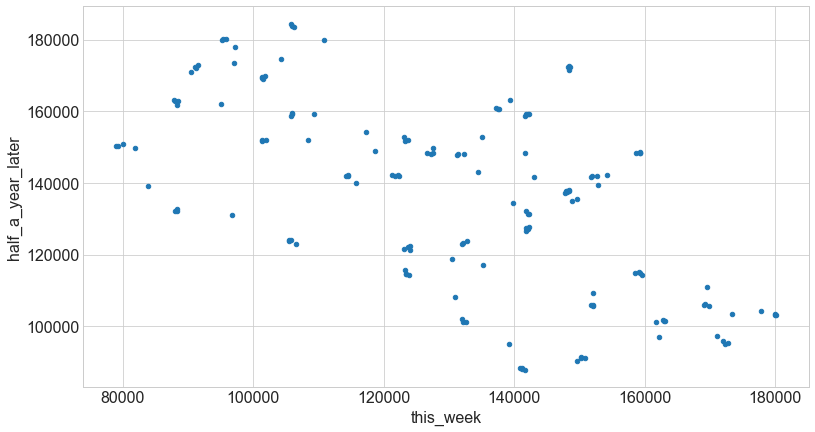

In [26]:
weekly['half_a_year_later'] = weekly.this_week.shift(-26)
weekly.plot.scatter(x='this_week', y='half_a_year_later')
weekly

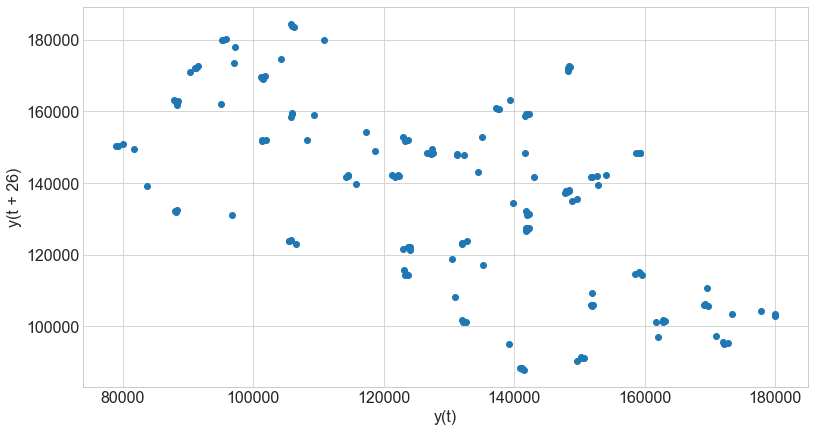

In [27]:
pd.plotting.lag_plot(y.sales_total.resample('W').mean(), lag=26);

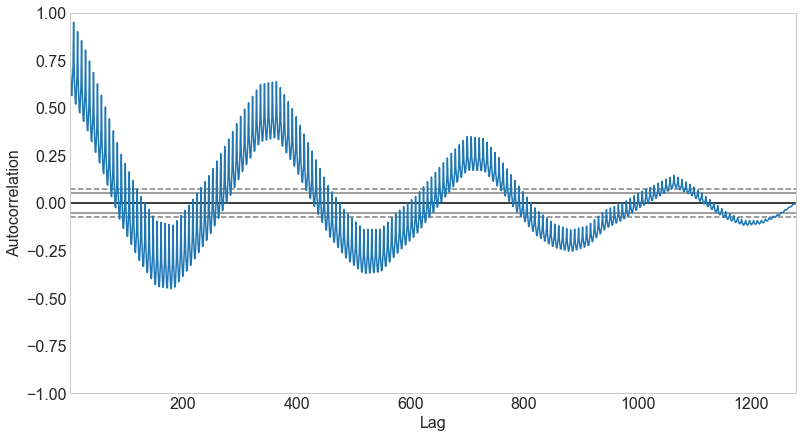

In [28]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('D').mean());

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

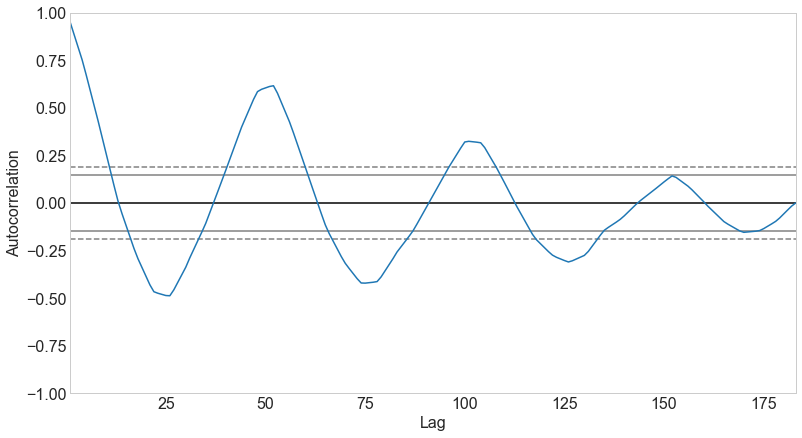

In [29]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('W').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

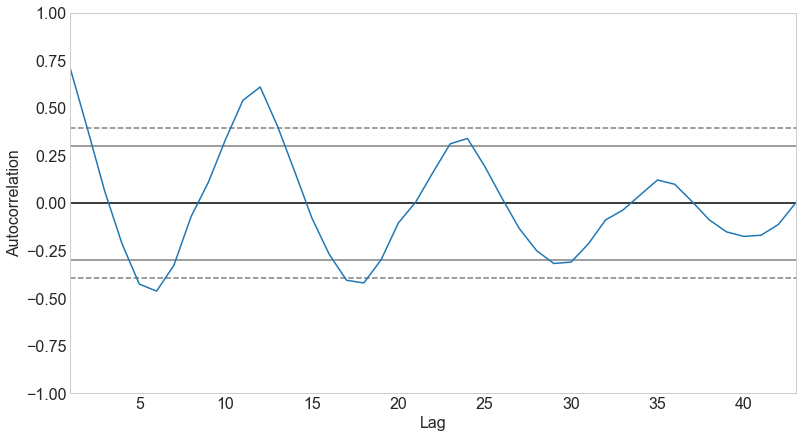

In [30]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

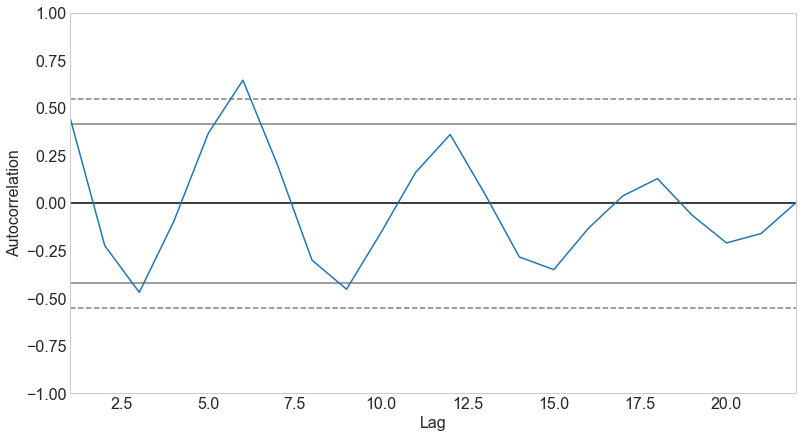

In [31]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('2M').mean())

# Decomposition

## `sales_total` Decomposition

In [32]:
y1 = train.sales_total.resample('W').mean()
result_sales = sm.tsa.seasonal_decompose(y1)

decomposition_sales = pd.DataFrame({
    'y': result_sales.observed,
    'trend': result_sales.trend,
    'seasonal': result_sales.seasonal,
    'resid': result_sales.resid
})

decomposition_sales.head()

,y,trend,seasonal,resid
2013-01-06,81794.583333,NaN,-38901.876390,NaN
2013-01-13,79990.601429,NaN,-38210.382887,NaN
2013-01-20,78973.360000,NaN,-38830.973862,NaN
2013-01-27,79272.691429,NaN,-38827.078436,NaN
2013-02-03,83792.507143,NaN,-36538.820195,NaN


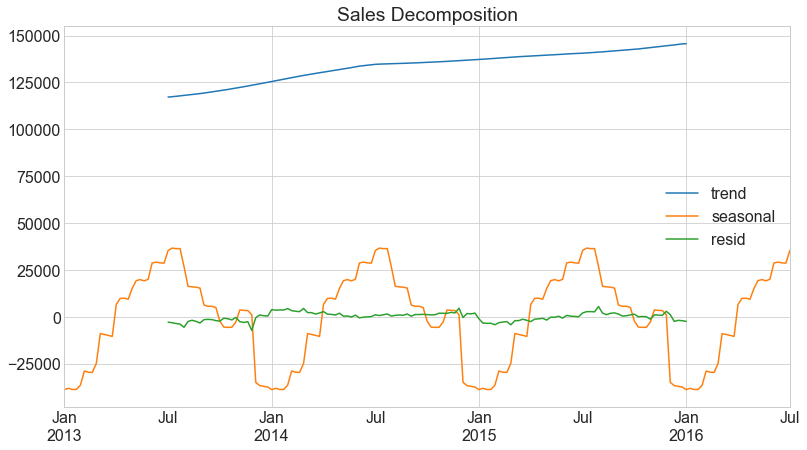

In [33]:
decomposition_sales.iloc[:, 1:].plot(title='Sales Decomposition');

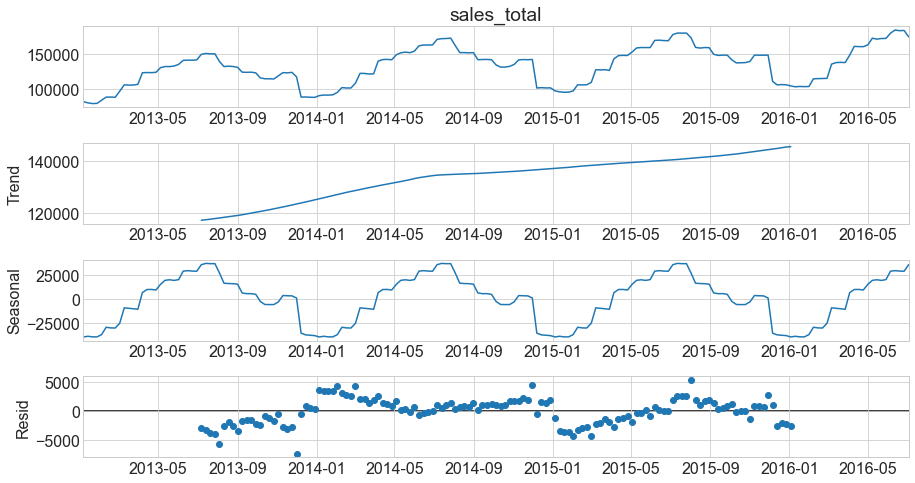

In [34]:
result_sales.plot()
None

## `quantity` Decomposition

In [35]:
y2 = train.quantity.resample('W').mean()
result_quantity = sm.tsa.seasonal_decompose(y2)

decomposition_quantity = (
    
    pd.DataFrame({'y': result_quantity.observed,
                  'trend': result_quantity.trend,
                  'seasonal': result_quantity.seasonal,
                  'resid': result_quantity.resid}
                ))

decomposition_quantity.head()

,y,trend,seasonal,resid
2013-01-06,15177.833333,NaN,-7237.504760,NaN
2013-01-13,14843.142857,NaN,-7128.032736,NaN
2013-01-20,14707.142857,NaN,-7213.079439,NaN
2013-01-27,14756.857143,NaN,-7217.573258,NaN
2013-02-03,15575.285714,NaN,-6809.896060,NaN


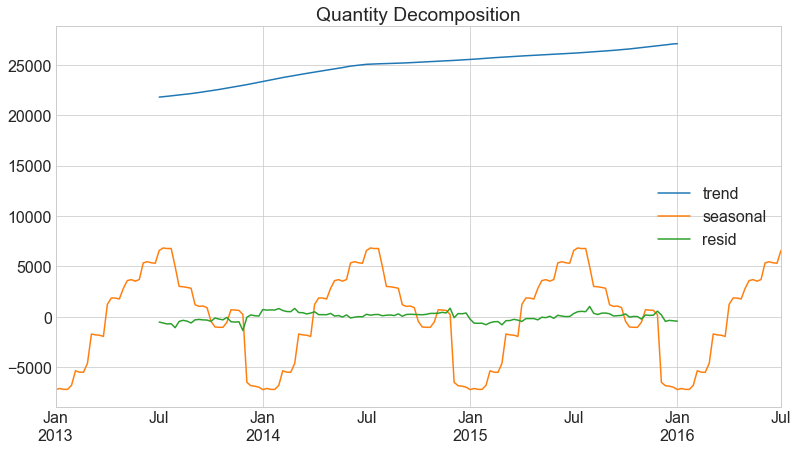

In [36]:
decomposition_quantity.iloc[:, 1:].plot(title='Quantity Decomposition');

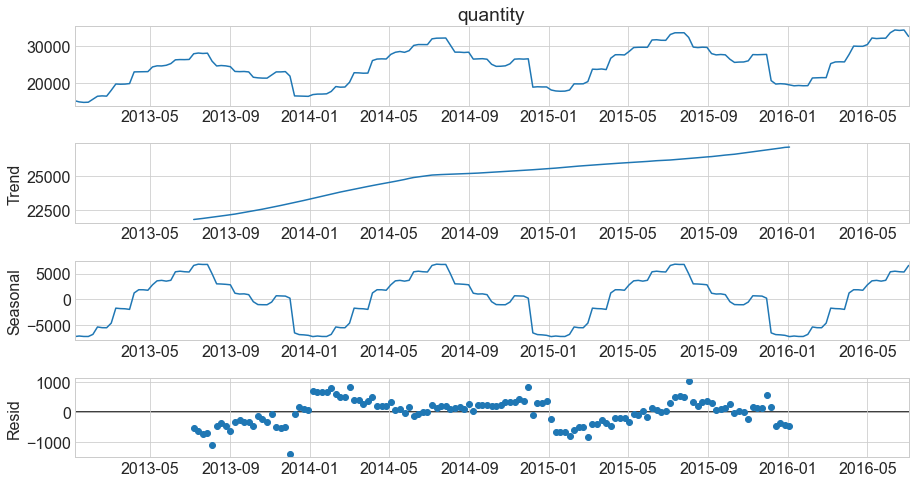

In [37]:
result_quantity.plot()
None

# Categorical Features

In [38]:
train['sales_binned'] = pd.qcut(train.sales_total, 3, labels=['low', 'medium', 'high'])

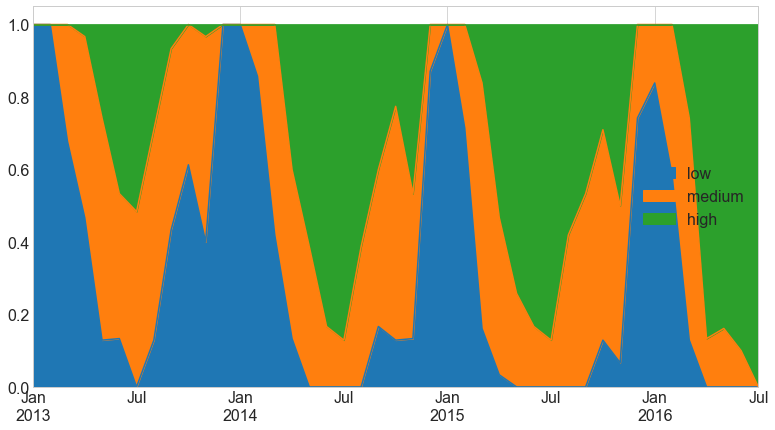

In [39]:
(train.groupby('sales_binned')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.legend(loc='best');

# Germany's Open Power Systems Data

In [62]:
df = prepare.prepare_ops_data(acquire.acquire_open_power_systems())

In [63]:
print(df.index.dtype)
df.head()

datetime64[ns]


,consumption,wind,solar,wind_and_solar,month,year
date,,,,,,
2006-01-01,1069.184,0.0,0.0,0.0,1,2006
2006-01-02,1380.521,0.0,0.0,0.0,1,2006
2006-01-03,1442.533,0.0,0.0,0.0,1,2006
2006-01-04,1457.217,0.0,0.0,0.0,1,2006
2006-01-05,1477.131,0.0,0.0,0.0,1,2006


In [57]:
df = df.assign(
    day_of_week = df.index.day_name()
)

In [58]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index]
test = df[test_start_index:] 

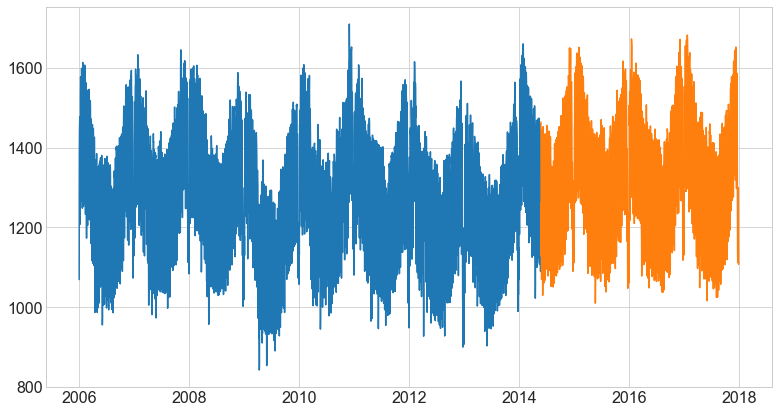

In [59]:
plt.plot(train.index, train.consumption)
plt.plot(test.index, test.consumption);

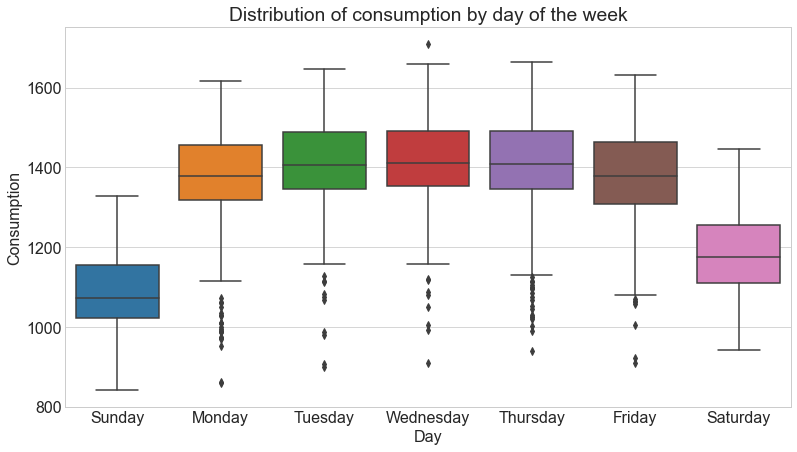

In [61]:
sns.boxplot(data=train, x='day_of_week', y='consumption')

plt.title('Distribution of consumption by day of the week')
plt.xlabel('Day')
plt.ylabel('Consumption');

# Decomposition

In [45]:
y = train.consumption.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
2006-01-01,1069.184000,NaN,-68.437315,NaN
2006-01-08,1381.300143,NaN,-125.834756,NaN
2006-01-15,1486.730286,NaN,35.842411,NaN
2006-01-22,1490.031143,NaN,106.451350,NaN
2006-01-29,1514.176857,NaN,122.022124,NaN


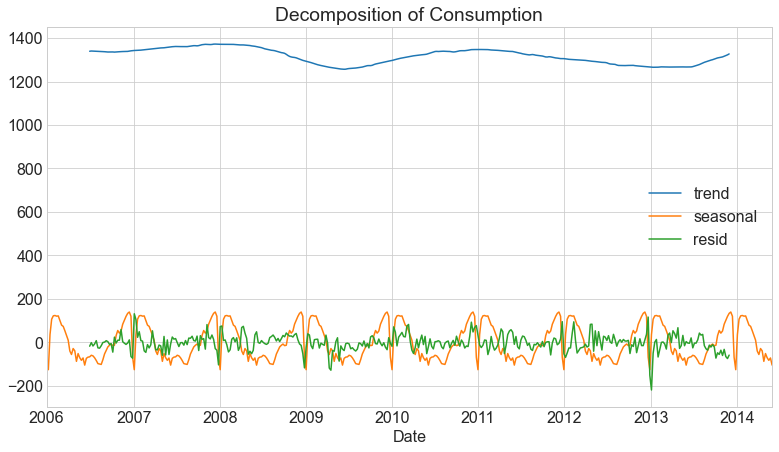

In [46]:
decomposition.iloc[:, 1:].plot(title='Decomposition of Consumption')
plt.xlabel('Date');

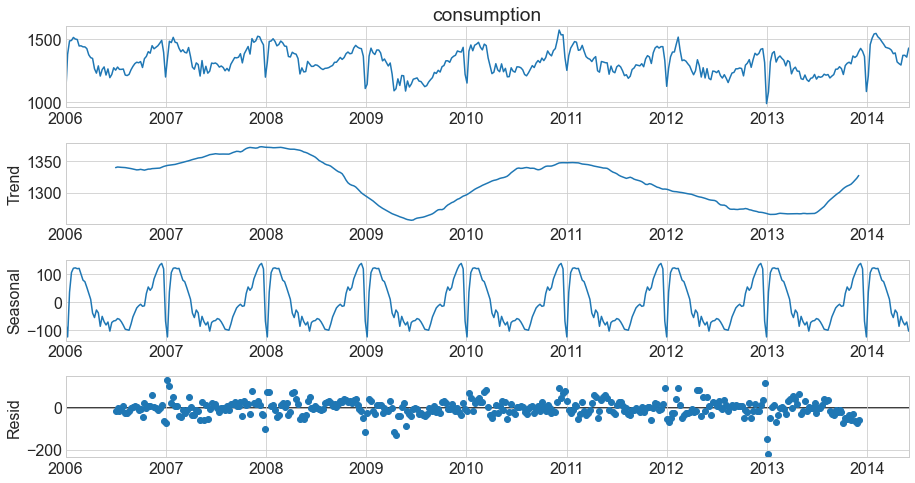

In [47]:
result.plot()
None

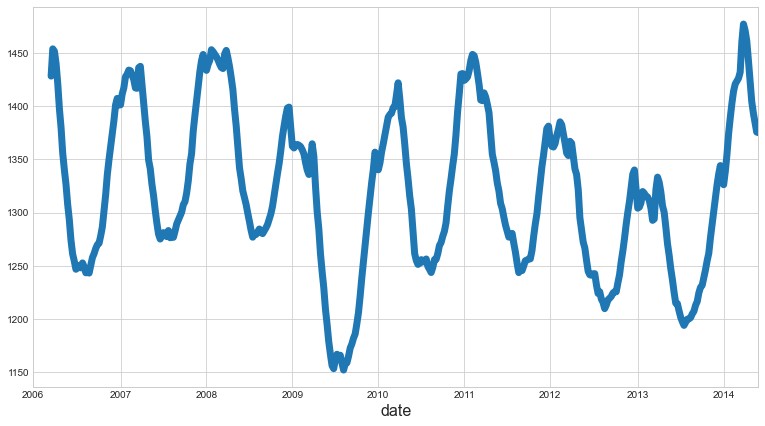

In [48]:
y.rolling(12).mean().plot(figsize=(13,7),
                          linewidth=7,
                          fontsize=10);

The recognized win_types are:
- boxcar
- triang
- blackman
- hamming
- bartlett
- parzen
- bohman
- blackmanharris
- nuttall
- barthann
- kaiser (needs parameter: beta)
- gaussian (needs parameter: std)
- general_gaussian (needs parameters: power, width)
- slepian (needs parameter: width)
- exponential (needs parameter: tau), center is set to None.



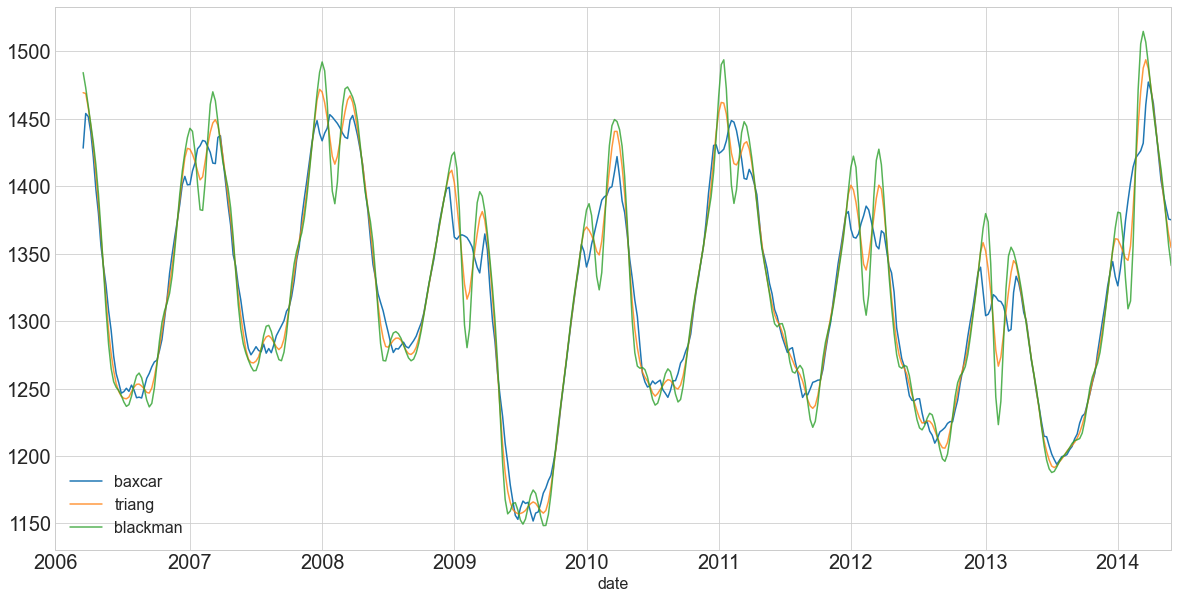

In [49]:
a=y.rolling(12, win_type='boxcar').mean().plot(figsize=(20,10), fontsize=20, label='baxcar')
b=y.rolling(12, win_type='triang').mean().plot(figsize=(20,10), fontsize=20, alpha=.8, label='triang')
c=y.rolling(12, win_type='blackman').mean().plot(figsize=(20,10), fontsize=20, alpha=.8, label='blackman')
plt.legend(a, b, c, labels=('baxcar','triang','blackman'));

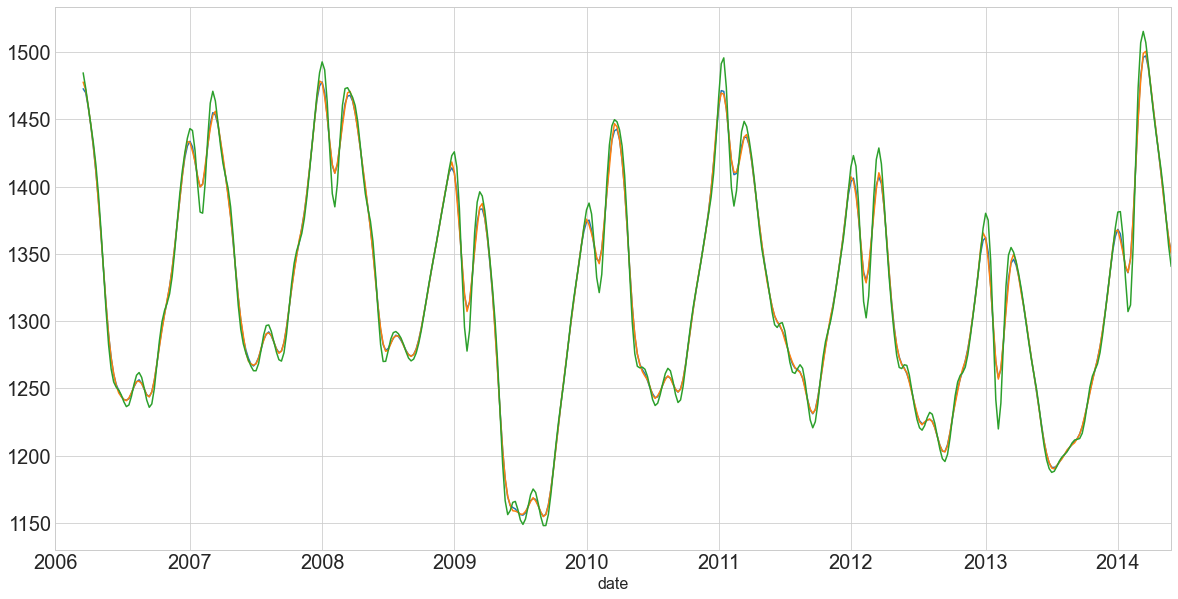

In [50]:
y.rolling(12, win_type='hamming').mean().plot(figsize=(20,10), fontsize=20)
y.rolling(12, win_type='bartlett').mean().plot(figsize=(20,10), fontsize=20)
y.rolling(12, win_type='parzen').mean().plot(figsize=(20,10), fontsize=20);

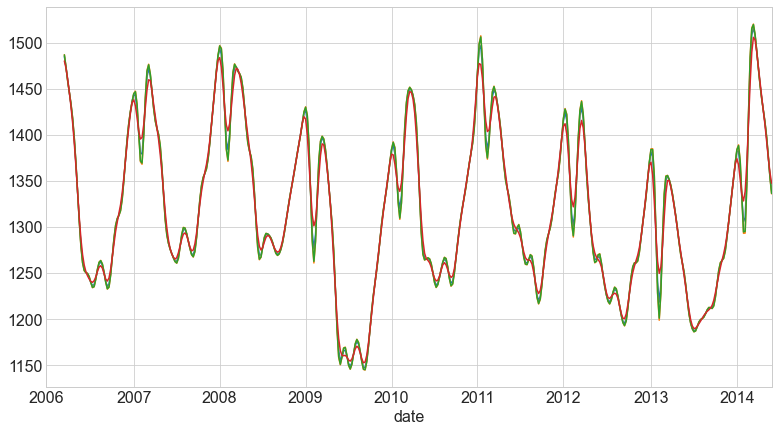

In [51]:
y.rolling(12, win_type='bohman').mean().plot()
y.rolling(12, win_type='blackmanharris').mean().plot()
y.rolling(12, win_type='nuttall').mean().plot()
y.rolling(12, win_type='barthann').mean().plot();

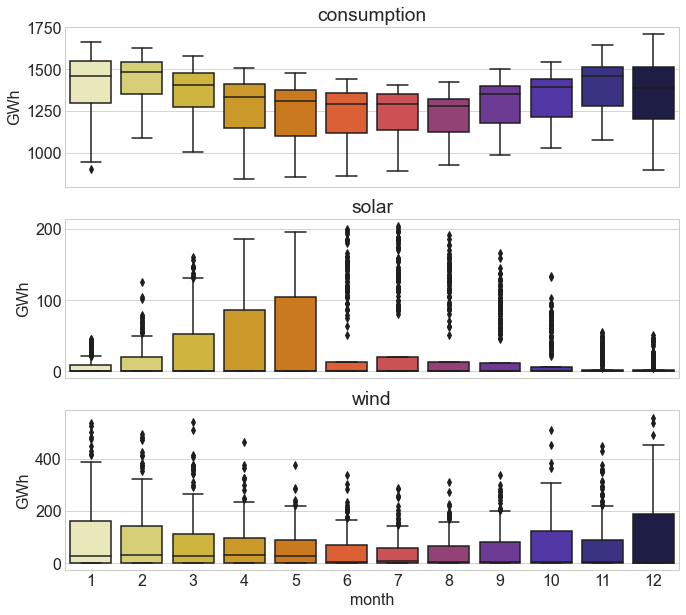

In [78]:
fig, axes = plt.subplots(3, figsize=(11, 10), sharex=True)

# zip together the column names with the number of subplots
for name, ax in zip(['consumption', 'solar', 'wind'], axes):
    sns.boxplot(data=train, x='month', y=name, ax=ax, palette='CMRmap_r')
    ax.set_ylabel('GWh')
    ax.set_title(name)
    # If the current plot is not the last plot, set the xlabel to an empty string
    if ax != axes[-1]:
        ax.set_xlabel('')